In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering
import pickle

In [122]:
def preprocess_and_cluster(input_data_path):
    """
    Preprocesses data, applies clustering, adds cluster labels,
    and provides recommendations based on the clusters.

    Parameters:
    - input_data_path: Path to the CSV file containing the input data.

    Returns:
    - clustered_data: DataFrame with clustered data, clustering labels, and recommendations.
    - clustering_model: Trained clustering model.
    """
    np.random.seed(42)
    #Load the input data
    df = pd.read_csv(input_data_path)
    
    #DATA CLEANING LOGIC
    
    #Removing the records with null values
    df.dropna(inplace=True)
    
    #Removing Duplicates
    df.drop_duplicates(inplace=True)
    
    
    #FEATURE ENGINEERTING AND PREPROCESSING LOGIC
    
    #Dt_Customer indicates date Customer joined database
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

    End_date = max(df['Dt_Customer'])
    Duration = []
    for d in df['Dt_Customer']:
        diff = End_date - d
        diff = pd.Timedelta(diff)
        Duration.append(diff.days)
        
    #Assigning the dates as a column within the dataframe
    df['Customer_For (Days)'] = Duration
    
    #Creating a new feature showing the Customer Age
    df['Cust_Age'] = 2021 - df['Year_Birth']
    
    #Calculating total expenditure per customer
    df['Spent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

    #Reducing Categorical Values in Marital_Status to Partner and Alone
    df['Lives_With'] = df['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})
    
    #Merging values in columns Kidhome and Teenhome
    df["No_of_Children"] = df['Kidhome'] + df['Teenhome']
    
    #Creating a new Column "Family_Size" indicating size of Customer Household
    df["Family_Size"] = df['Lives_With'].replace({"Alone":1, "Partner":2}) + df['No_of_Children']
    
    #If the condition is true (i.e., if the value in the "Children" column is greater than 0), the corresponding element in the new "Is_Parent" column is set to 1. If the condition is false, the corresponding element is set to 0.
    df['Is_Parent'] = np.where(df['No_of_Children'] > 0, 1, 0)
    
    #Reducing Categorical Values of Education into 3: UnderGrad, Grad, PostGrad
    df["Education"] = df['Education'].replace({"Basic":"UnderGrad", "2n Cycle":"UnderGrad", "Graduation":"Grad", "Master":"PostGrad", "PhD":"PostGrad"})
    
    #Renaming Columns
    df = df.rename(columns={"MntWines":"Wines", "MntFruits":"Fruits", "MntMeatProducts":"Meat", "MntFishProducts":"Fish", "MntSweetProducts":"Sweets", "MntGoldProds":"Gold"})
    
    #Retaining the new features generated and removing the old ones
    df = df.drop(columns={'Dt_Customer', 'Marital_Status', 'Year_Birth', 'ID', 'Z_CostContact', 'Z_Revenue'}, axis = 1)
    
    #Filtering outliers
    df = df[df["Cust_Age"]<90]
    df = df[df['Income'] < 600000]
    
    #Determining non-numerical variables
    for column_name, dt in df.dtypes.items():
        if dt == 'object':
            print(f"{column_name}: {dt}")
    
    #Performing Label Encoding
    enc = LabelEncoder()
    df['Education'] = df[['Education']].apply(enc.fit_transform)
    df['Lives_With'] = df[['Lives_With']].apply(enc.fit_transform)
    
    ds = df.copy()

    del_col = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response']

    ds = ds.drop(del_col, axis =1)
    
    scaler = StandardScaler()

    scaler.fit(ds)

    scaled_ds = pd.DataFrame(scaler.transform(ds), columns = ds.columns)
    scaled_ds
    
    #Using PCA to reduce dimensions(features) to 3 
    pca = PCA(n_components=3)
    pca.fit(scaled_ds)
    PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns = (['Col1', 'Col2', 'Col3']))
    
    
    x = PCA_ds['Col1']
    y = PCA_ds['Col2']
    z = PCA_ds['Col3']
    
    #Elbow Method to Determine the Optimum Number of Clusters
    Elbow_M = KElbowVisualizer(KMeans(), k=10)
    Elbow_M.fit(PCA_ds)
    Elbow_M.show()
    # Load the existing clustering model
    with open('Cluster.pkl', 'rb') as data_file:
        clustering_model = pickle.load(data_file)
    
    yhat_AC = clustering_model.fit_predict(PCA_ds)
    
    df["Clusters"] = yhat_AC
    
    #Visualizing Number Distribution Among Clusters
    figure = sns.countplot(x= df['Clusters'], palette="tab10")
    figure.set_title("Cluster Distribution")
    plt.show()
    
    #Visualizing the Cluster Within Income and Spending
    figure = sns.scatterplot(data = df, x = df['Spent'], y = df['Income'], hue = df['Clusters'], palette="tab10")
    figure.set_title("Clusters Within Income and Spending")
    figure.legend()
    plt.show()
    
    
    Personal = ["No_of_Children", "Customer_For (Days)", "Cust_Age", "Teenhome", "Spent", "Income"]

    #Visualizing Distribution Among Clusters
    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Flatten the axes array to iterate through it
    axes = axes.flatten()

    # Loop through each feature and create a violin plot
    for i, feature in enumerate(Personal):
        figure = sns.violinplot(x=df["Clusters"], y=df[feature], ax=axes[i], hue=df['Clusters'], palette="tab10")

        figure.xaxis.set_major_locator(plt.MaxNLocator(20))
        figure.yaxis.set_major_locator(plt.MaxNLocator(20))
    # Adjust layout
    plt.tight_layout()
    plt.legend(loc = 'upper center')

    plt.show()
    # Define recommendation strategies based on clusters
    def recommend_products(cluster_label):
        if cluster_label == 0:
            return "Recommend high-value products suitable for older parents. Consider loyalty programs."
        elif cluster_label == 1:
            return "Consider diverse marketing strategies targeting a wide age range. Highlight high-income products."
        elif cluster_label == 2:
            return "Tailor offerings to younger parents with more budget-friendly options."
        elif cluster_label == 3:
            return "Focus on personalized and high-value offerings for the smallest, older parent group."
        else:
            return "No specific recommendation for this cluster."

    # Apply recommendations to each customer in the DataFrame
    df["Recommendation"] = df["Clusters"].apply(recommend_products)

    # Merge the recommendation column back to the original input data using the customer identifier (e.g., ID)
    
    original_df = pd.read_csv(input_data_path)
    original_df.insert(0, "Recommendation", df["Recommendation"])

    return df, clustering_model

C:\Users\Bildad Otieno\AppData\Local\Temp\ipykernel_25488\984692405.py:29: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])


Education: object
Lives_With: object


c:\Users\Bildad Otieno\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bildad Otieno\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bildad Otieno\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Bildad Otieno\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

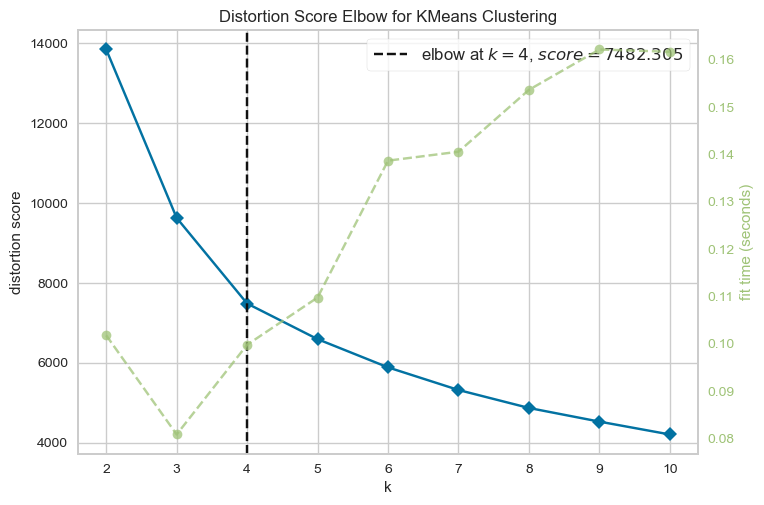

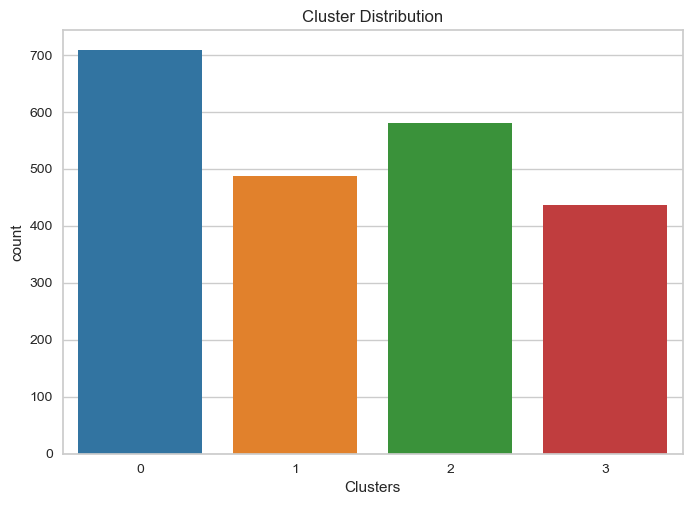

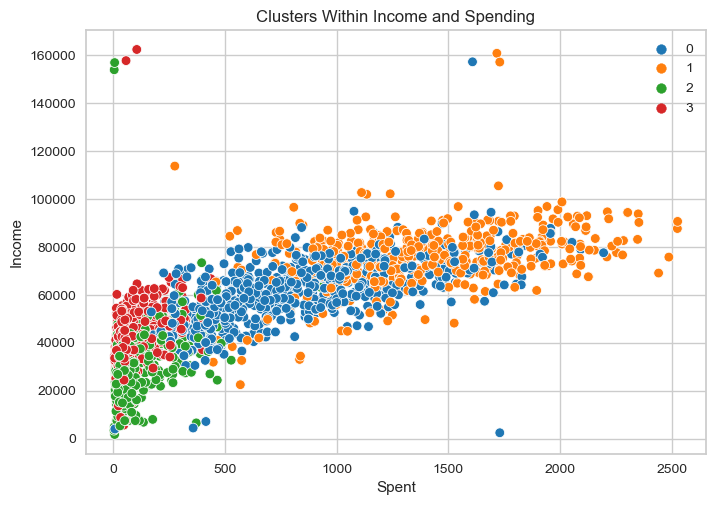

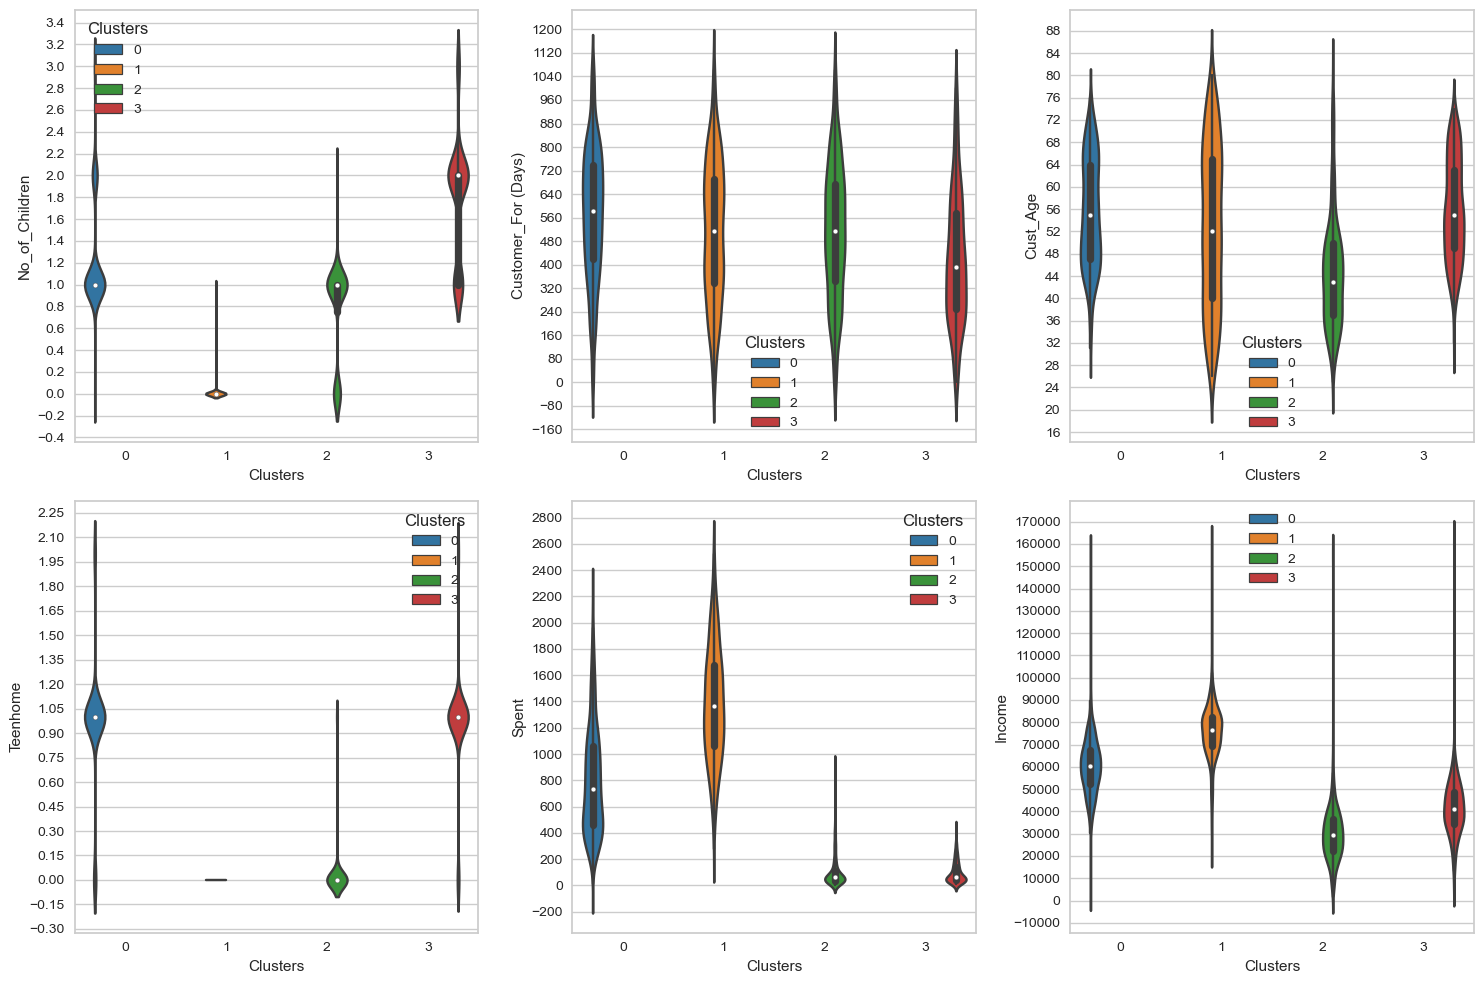

(      Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  \
 0             0  58138.0        0         0       58    635      88   546   
 1             0  46344.0        1         1       38     11       1     6   
 2             0  71613.0        0         0       26    426      49   127   
 3             0  26646.0        1         0       26     11       4    20   
 4             1  58293.0        1         0       94    173      43   118   
 ...         ...      ...      ...       ...      ...    ...     ...   ...   
 2235          0  61223.0        0         1       46    709      43   182   
 2236          1  64014.0        2         1       56    406       0    30   
 2237          0  56981.0        0         0       91    908      48   217   
 2238          1  69245.0        0         1        8    428      30   214   
 2239          1  52869.0        1         1       40     84       3    61   
 
       Fish  Sweets  ...  Response  Customer_For (Days)  Cust_

In [123]:
csv_file =  r'Mall_Customers.csv'


new_data = preprocess_and_cluster(csv_file)

new_data

In [124]:
new_data['Clusters']

TypeError: tuple indices must be integers or slices, not str